This project is to generate captions on images. This problem usually seen as an example of the power of deep learning because it uses deeplearning to run classification on the images and to generate texts. 

This project uses the Oxford Visual Geometry Groups VGG model to run classification on the images. Then instead of using the final softmax output we take the features from the last fully connected layer. We then feed these features into an LSTM to generate captions, word by word. This LSTM is trained on a database of images from Flickr with captions generated by crowdflower. 

Attributions:

Thanks to machinelearning.com. This project is from his DL for NLP book.

For the VGG Model:  
@InProceedings{Simonyan15,  
  author       = "Karen Simonyan and Andrew Zisserman",  
  title        = "Very Deep Convolutional Networks for Large-Scale Image Recognition",  
  booktitle    = "International Conference on Learning Representations",  
  year         = "2015",  
}

For the data:  
M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artifical Intellegence Research, Volume 47, pages 853-899  
http://www.jair.org/papers/paper3994.html


## Import Libraries

In [1]:
from os import listdir
from os import path
import pickle
import random
import datetime
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.models import Model
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, add
import tensorflow.keras as tk
from tensorflow.keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
from IPython.display import Image 

In [2]:
%load_ext tensorboard

## Data Engineering

In [3]:
# function to load the images
def load_photos(directory):
    images = dict()
    for name in listdir(directory):
        # load image
        filename = path.join(directory, name)
        image = load_img(filename, target_size=(224,224))
        # convert image to array
        image = img_to_array(image)
        # reshape data
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # normalize images with parameters for the model
        image = preprocess_input(image)
        # get the image id
        image_id = name.split('.')[0]
        images[image_id] = image
    return images

In [4]:
# function to run the images through the VGG model and save the features
# purpose is so that we don't have to run two models at a time later when we train the text generator 
def extract_features(directory):
    # import the VGG model
    model = VGG16()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # remove the last layer of the model so that we can take those as input for the model
    model.summary()
    features = dict()
    images = load_photos(directory)
    for image_id, image in images.items():
        feature = model.predict(image, verbose=0)
        features[image_id] = feature
    return features

In [5]:
# extracting and saving the features
directory = 'Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features = ', len(features))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

KeyError: 0

In [15]:
#fixing the above error where I was trying to check the feature dimensions
random.choice(list(features.items()))[1].shape

(1, 4096)

In [6]:
pickle.dump(features, open('features.pkl', 'wb'))

In [5]:
# opens a text file reads it and saves it to an object
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [6]:
# extracting the captions 
def load_captions(doc):
    captions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line)<2:
            continue
        # in the file, the first token of each line is the image id
        image_id, image_caption = tokens[0], tokens[1:]
        # remove the filename from the image id
        image_id = image_id.split('.')[0]
        # convert the image description back into text
        image_caption = ' '.join(image_caption)
        # initiate the list in the dictionary if not already
        if image_id not in captions:
            captions[image_id] = list()
        captions[image_id].append(image_caption)
    return captions

In [7]:
# perform some basic clean up on the captions
def clean_captions(captions):
    for _, captions_list in captions.items():
        for i in range(len(captions_list)):
            caption = captions_list[i]
            # break the caption into words, also makes lowercase
            caption = word_tokenize(caption)
            # removes single characters
            caption = [word for word in caption if len(word)>1]
            # removes punctuation and numbers
            caption = [word for word in caption if word.isalpha()]
            # store again as a string
            captions_list[i] = ' '.join(caption)
    return captions

In [8]:
# use the captions to generate a vocabulary for the captions
def gen_vocab(captions):
    vocab = set()
    for image_id in captions.keys():
        [vocab.update(word_tokenize(caption)) for caption in captions[image_id]]
    return vocab

In [9]:
# save the captions to a file to be used again
def save_captions(captions, filename):
    lines = list()
    for image_id, caption_list in captions.items():
        for caption in caption_list:
            lines.append(image_id + ' ' + caption)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [10]:
filename = 'Flickr8k_text/Flickr8k.token.txt'
doc = load_doc(filename)
captions = load_captions(doc)
print('Loaded:', len(captions))

Loaded: 8092


In [11]:
print('Caption sample:', random.choice(list(captions.items())))

Caption sample: ('2511019188_ca71775f2d', ['A dog with a Frisbee in front of a brown dog .', 'A large black dog is catching a Frisbee while a large brown dog follows shortly after .', 'Two dark colored dogs romp in the grass with a blue Frisbee .', 'Two dogs are catching blue Frisbees in grass .', 'Two dogs are playing ; one is catching a Frisbee .'])


In [12]:
captions = clean_captions(captions)
vocabulary = gen_vocab(captions)
print('Vocab Size:', len(vocabulary))
save_captions(captions, 'captions.txt')

Vocab Size: 9054


## Load and transform data

In [13]:
# load list of images
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line)<1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

In [14]:
def load_formated_captions(filename, dataset):
    doc = load_doc(filename)
    captions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_caption = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in captions:
                captions[image_id] = list()
            caption = 'startseq ' + ' '.join(image_caption) + ' endseq'
            captions[image_id].append(caption)
    return captions

In [15]:
def load_photo_features(filename, dataset=None):
    all_features = pickle.load(open(filename, 'rb'))
    if dataset:
        features = {k: all_features[k] for k in dataset}
        return features
    else:
        return all_features

In [16]:
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset:', len(train))
train_captions = load_formated_captions('captions.txt', train)
print('Training Captions:', len(train_captions))
train_features = load_photo_features('features.pkl', train)
print('Training Images:', len(train_features))

Dataset: 6000
Training Captions: 6000
Training Images: 6000


In [17]:
# creating a tokenizer on the dictionary means we need unpack the dictionary into a list of lists
def create_tokenizer(captions):
    lines = list()
    for caption_list in captions.values(): 
        [lines.append(caption) for caption in caption_list]
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [18]:
# creating the tokenizer
tokenizer = create_tokenizer(train_captions)
# the dimension that we pass into the algorithms needs to be 1 larger than the vocab size
vocab_dim = len(tokenizer.word_index) + 1
print('vocab_dim:', vocab_dim)

vocab_dim: 7268


In [20]:
# save the tokenizer
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [19]:
# getting the max length of the captions
def get_max_length(captions):
    lines = list()
    for caption_list in captions.values(): 
        [lines.append(caption) for caption in caption_list]
    return max(len(line.split()) for line in lines)

In [20]:
# transform the data to be used for model training
def gen_Xy(captions, max_length, features, tokenizer):
    # we need two training feature arrays, and a training target array
    X1, X2, y = list(), list(), list()
    # extract these to shape the arrays
    vocab_dim = len(tokenizer.word_index) + 1
    # generate the training features for the text data
    for image_id, caption_list in captions.items():
        for caption in caption_list:
            seq = tokenizer.texts_to_sequences([caption])[0]
            # generate partial sequences
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                # pad the partial sequence for consistent input length
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_dim)[0]
                # store into the training features and target array
                X1.append(features[image_id][0])
                X2.append(in_seq)
                y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [21]:
max_length = get_max_length(train_captions)

In [22]:
# transform the training data
X1train, X2train, ytrain = gen_Xy(train_captions, max_length, train_features, tokenizer)
print(X1train.shape, X2train.shape, ytrain.shape)

(305623, 4096) (305623, 33) (305623, 7268)


In [23]:
# load and transform the testing data
filename = 'Flickr8k_text/Flickr_8k.devImages.txt'
test = load_set(filename)
print('Dataset:', len(test))
test_captions = load_formated_captions('captions.txt', test)
print('Test Captions:', len(test_captions))
test_features = load_photo_features('features.pkl', test)
print('Test Images:', len(test_features))
X1test, X2test, ytest = gen_Xy(test_captions, max_length, test_features, tokenizer)
print(X1test.shape, X2test.shape, ytest.shape)

Dataset: 1000
Test Captions: 1000
Test Images: 1000
(50835, 4096) (50835, 33) (50835, 7268)


## Build the model

In [29]:
# keras allows us to use the functional method of building models to build a model with two inputs
def build_model(tokenizer):
    # extract these to shape the arrays
    max_length = get_max_length(train_captions)
    vocab_dim = len(tokenizer.word_index) + 1
    # apply dropout and fully connected layer to the photo features
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # apply embedding and LSTM layer to the text
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_dim, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # apply a fully connected layer to the photos neural net and the text LSTM
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_dim, activation='softmax')(decoder2)
    # create the final model
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    # see model stats
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [30]:
model = build_model(tokenizer)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 33)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 33, 256)      1860608     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_1[0][0]                    
______________________________________________________________________________________________

# Compile and train the model

In [31]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
# set callbacks
checkpoint_callback = tk.callbacks.ModelCheckpoint('model.h5', 
                                                   monitor='val_loss', 
                                                   verbose=1, 
                                                   save_best_only=True, 
                                                   mode='min')

log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tb_callback = tk.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# fir the model
model.fit([X1train, X2train], ytrain, 
          epochs=8, 
          callbacks = [checkpoint_callback, tb_callback], 
          validation_data=([X1test, X2test], ytest))

Train on 305623 samples, validate on 50835 samples
Epoch 1/8
305600/305623 [============================>.] - ETA: 0s - loss: 4.0587 - accuracy: 0.2718
Epoch 00001: val_loss improved from inf to 3.97679, saving model to model.h5
305623/305623 [==============================] - 776s 3ms/sample - loss: 4.0587 - accuracy: 0.2718 - val_loss: 3.9768 - val_accuracy: 0.2835
Epoch 2/8
305600/305623 [============================>.] - ETA: 0s - loss: 3.7269 - accuracy: 0.2928
Epoch 00002: val_loss improved from 3.97679 to 3.88212, saving model to model.h5
305623/305623 [==============================] - 769s 3ms/sample - loss: 3.7270 - accuracy: 0.2928 - val_loss: 3.8821 - val_accuracy: 0.2956
Epoch 3/8
305600/305623 [============================>.] - ETA: 0s - loss: 3.5821 - accuracy: 0.3015
Epoch 00003: val_loss did not improve from 3.88212
305623/305623 [==============================] - 771s 3ms/sample - loss: 3.5820 - accuracy: 0.3015 - val_loss: 3.8943 - val_accuracy: 0.2985
Epoch 4/8
3056

Looks like the model is best at epoch 2.

In [7]:
%tensorboard --logdir logs/fit --host localhost

## Evaluate model

Using the best model from the training, we will evaluate the model against the test corpus, using BLEU Scores.

In [41]:
# create caption using the model with the tokenizer and image
def generate_caption(model, tokenizer, image_feature, max_length):
    ix_to_word = dict((i,c) for c,i in tokenizer.word_index.items())
    # sequence starts with 'start seq'
    in_text = 'startseq'
    for i in range(max_length):
        # use the tokenizer to convert the sequence to numbers
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict the next word
        yhat = model.predict([image_feature,sequence], verbose=0)
        # map the prediction to a word
        yhat = np.argmax(yhat)
        word = ix_to_word[yhat]
        # error checking
        if word is None:
            break
        # add the word to the text
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

In [28]:
def cleanup_caption(caption):
    index = caption.find('startseq ')
    if index > -1:
        caption = caption[len('startseq '):]
    index = caption.find(' endseq')
    if index > -1:
        caption = caption[:index]
    return caption

In [43]:
# evaluate the model using BLEU scores
def evaluate_model(model, test_captions, test_features, tokenizer, max_length):
    actual, predicted = list(), list()
    # generate caption against each test caption
    for key, caption_list in test_captions.items():
        predicted_caption = generate_caption(model, tokenizer, test_features[key], max_length)
        predicted_caption = cleanup_caption(predicted_caption)
        # store the predicted and actual captions
        # transform the captions list and append to actuals list
        references = [cleanup_caption(caption).split() for caption in caption_list]
        actual.append(references)
        # append the caption to the predicted list, tokenized for the BLEU score algorithm
        predicted.append(predicted_caption.split())
    # calculate and return the BLEU scores
    BLEU = dict()
    BLEU[1] = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    BLEU[2] = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    BLEU[3] = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))
    BLEU[4] = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    return BLEU

In [33]:
# load and transform evaluation data
filename = 'Flickr8k_text/Flickr_8k.testImages.txt'
evaluation = load_set(filename)
print('Dataset:', len(evaluation))
evaluation_captions = load_formated_captions('captions.txt', evaluation)
print('Evaluation Captions:', len(evaluation_captions))
evaluation_features = load_photo_features('features.pkl', evaluation)
print('Evaluation Images:', len(evaluation_features))
X1eval, X2eval, yeval = gen_Xy(evaluation_captions, max_length, evaluation_features, tokenizer)
print(X1test.shape, X2test.shape, ytest.shape)

Dataset: 1000
Evaluation Captions: 1000
Evaluation Images: 1000
(50835, 4096) (50835, 33) (50835, 7268)


In [44]:
# load and evaluate the model
filename = 'model.h5'
model = load_model(filename)
BLEU = evaluate_model(model, evaluation_captions, evaluation_features, tokenizer, max_length)

In [45]:
# print the scores which were stored in a dictionary
print(BLEU)

{1: 0.4141519250780437, 2: 0.22160581655839307, 3: 0.11581047082674645, 4: 0.05929737477208823}


## Generate captions for a new image

In [53]:
# load everything needed to generate new captions
tokenizer = pickle.load(open('tokenizer.pkl', 'rb'))
max_length = 33
model = load_model('model.h5')

In [52]:
# extract features from the photo I have in the sample library
photo_features = extract_features('sample')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [59]:
photo = list(photo_features.values())[0]

In [60]:
caption = generate_caption(model, tokenizer, photo, max_length)
caption = cleanup_caption(caption)

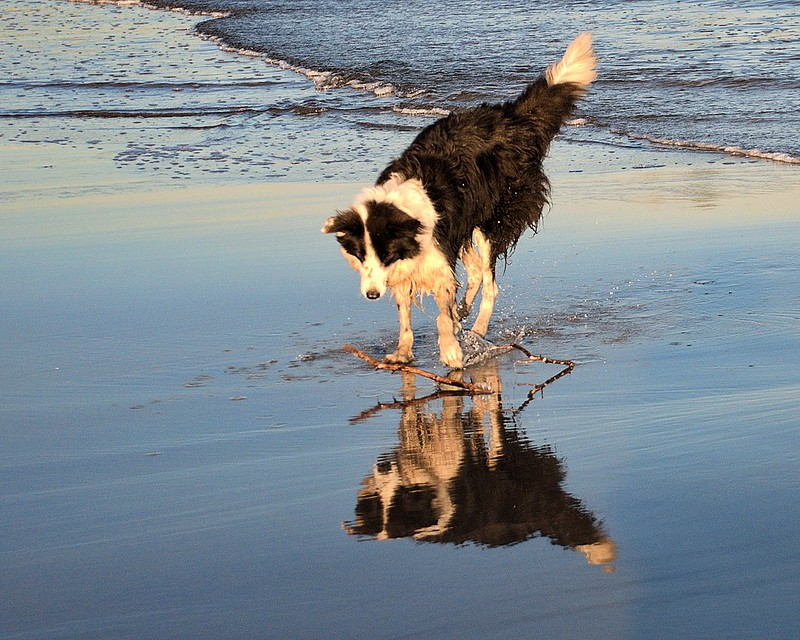

black dog is running through the water


In [65]:
image = Image('sample/sample.jpg')
display(image)
print(caption)

That's really not a bad caption! The dog isn't totally black but he's mostly black and he is indeed running through the water.